# Clustering of SuperDARN HF Radar Data 
***

This notebook is intended to give a quick start to new users of SuperDARN data, starting from scratch by obtaining backscatter data from the server, and finishing with a simple yet insightful clustering of the backscatter data. 

After completing this notebook, you will succeed in:
1. Obtaining a brief explanation of important terms related to backscatter clustering
2. Writing code for getting backscatter data from Virginia Tech's SuperDARN server using DaViT-py
3. Writing code for clustering backscatter into ground and ionospheric scatter using K-means, Agglomerative and Gaussian Mixture Models.

## Step 1: Backscatter Clustering: Important Terms

###  [Ionosphere](https://en.wikipedia.org/wiki/Ionosphere)
The ionosphere is the ionized part of the Earth's atmosphere, caused due to the due to the presence of ultraviolet radiation from the Sun, and located at a distance of 60 km to 1,000 km. It forms the inner edge of the magnetosphere and influences radio propagation to various places on Earth. The various layers include the D layer, E layer and F layer (additionally into F1 and F2 layers). Layers of significant ionization vary by day and night, with the F2 layer persisting by day and night and responsible for the refraction and reflection of radio waves.

### [SuperDARN](https://en.wikipedia.org/wiki/Super_Dual_Auroral_Radar_Network)
The Super Dual Auroral Radar Network (SuperDARN) is a network of ground-based coherent-scatter radars that operate in the HF band and whose fields of view combine to cover extensive regions of both the Northern and Southern hemisphere polar ionospheres __[[1]](https://www.bas.ac.uk/project/superdarn/)__. The radars focus on high and mid latitudes using coherent backscatter of radio waves and primarily map high latitude plasma convection in the F region of the ionosphere. SuperDARN also studies a wider range of geospace phenomena including field-aligned currents, magnetic reconnection and geomagnetic storms.

### [Backscattering](https://en.wikipedia.org/wiki/Backscatter)
Backscattering is the reflection of waves, particles, or signals back to the direction from which they came. In some cases, the scattering intensity is enhanced in the backward direction. One of the reasons for enhancement can be *coherent backscattering*. Coherent backscatter __[[2]](https://en.wikipedia.org/wiki/Coherent_backscattering)__ is similar to Bragg scattering in crystals and involves the constructive interference of scattering from ionospheric density irregularities. A coherent scatter radar focuses majorly on large amplitude structures aligned with the magnetic field. 

### Ground vs Ionospheric Backscatter
Depending on the propagation paths of signals backscattered, we can classify backscatter as ionospheric scatter if it is reflected from plasma irregularities or as ground scatter if reflected from the ground __[[3]](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2011RS004676)__. One of the traditional distinguishing feature of ground backscatter is its comparatively lower Doppler velocity and Doppler spectral width. In this notebook we will apply the unsupervised technique of clustering on ground and ionospheric backscatter.



## Step 2: Getting backscatter data from SuperDARN

In [1]:
%pylab inline
import davitpy.pydarn.sdio as sdio
import davitpy.pydarn.proc.fov.update_backscatter as ub
from sklearn import preprocessing
from sklearn import cluster
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from collections import defaultdict
import datetime as dt
import numpy as np
import pickle
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
#chosing the date range in which we wish to get the SuperDARN data
start_time = dt.datetime(2011,1,1,0)
end_time = dt.datetime(2011,1,1,1)

#chosing the radar name with 'sas' standing for the Saskatoon radar
radar_name = 'sas'

In [3]:
#establishing a data pipeline to the Virginia Tech SuperDARN server which wil return pointers to beam data class objects of type radDataPtr
data_ptr = sdio.radDataOpen(start_time,radar_name,end_time)

In [4]:
#processing beam data using the update_backscatter function by updating the propagation path, elevation, backscatter type,and origin field-of-view (FoV) for all backscatter observations
#update_backscatter.py module does some nice processing to remove errors in the elevation angle and ground flags (gflg)
#the elevation angle is an important attribute in our future clustering experiment
processed_beams = ub.update_backscatter(data_ptr)

In [5]:
#creating a dictionary with value type defaulting to a list
data = defaultdict(list)
#getting attributes: range gate, power, doppler velocity, spectral width, elevation for future clusterig
for key in processed_beams.keys():
    for i in range(len(processed_beams[key])):
        beam = processed_beams[key][i]
        #discard beam indices which have elevation angle equal to nan
        good_indices = np.where(np.isfinite(np.array(beam.fit.fovelv)))
        #since we have used a defaultdict list data structure, we can use += instead of append
        #which will directly give a flat list of attribute values for clustering 
        #using append would have resulted in a nested list structure
        data["gate"] += (np.array(beam.fit.slist)[good_indices]).tolist() 
        data["power"] += (np.array(beam.fit.p_l)[good_indices]).tolist()           
        data["velocity"] += (np.array(beam.fit.v)[good_indices]).tolist()            
        data["width"] += (np.array(beam.fit.w_l)[good_indices]).tolist()            
        data["elevation"] += (np.array(beam.fit.fovelv)[good_indices]).tolist()     

In [6]:
#saving the data in a pickle file for future offline use if needed (optional)
with open("radar_data_" + str(str(start_time).split(' ')[0]) + "_" + radar_name + ".pkl", "wb") as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close() 

# Clustering of Backscatter echoes in SuperDARN data 

The idea is to cluster the backscatter echoes into ground scatter and ionospheric scatter by using three different clustering algorithms

In [7]:
#load the saved data from the same file as given above
filename = "radar_data_" + str(str(start_time).split(' ')[0]) + "_" + radar_name + ".pkl"
data = pickle.load(open(filename, "rb"))  

In [8]:
#preprocess all data to appropriately scale     
for key in data.keys():
    data[key] = preprocessing.scale(data[key])    

#stack data into columns and obtain an attribute name list for future ploting
X = np.array(data["width"])
attributes = ["width"]
X = X.reshape(X.shape[0], 1)        
for key in data.keys():
    if key== "width":
        continue
    X = np.hstack((X, np.array(data[key]).reshape(X.shape[0], 1)))    
    attributes.append(key)  

## K-Means Clustering

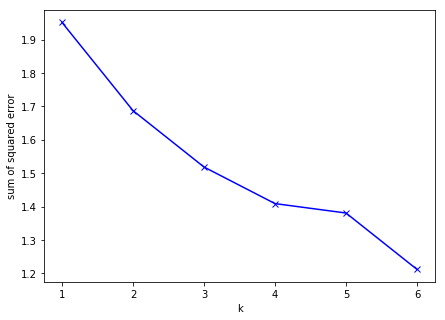

In [9]:
pylab.rcParams['figure.figsize'] = (7, 5)

#finding the value of number of clusters to be used by the elbow curve.
#the elbow method looks at the percentage of variance as a function of the number of clusters
#the cluster size with sufficiently minimum variance (located at the 'elbow' of the curve) is taken

#setting the range for number of clusters
k_choices = range(1, 7)

#initializing different k-means models based on the number of clusters
kmeans_model = [cluster.KMeans(n_clusters = k) for k in k_choices]

#run all models
[model.fit(X) for model in kmeans_model]   
#compute variance (sum of squared error)
distortions = [sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0] for model in kmeans_model]
plt.plot()
plt.plot(k_choices, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared error')
plt.show()

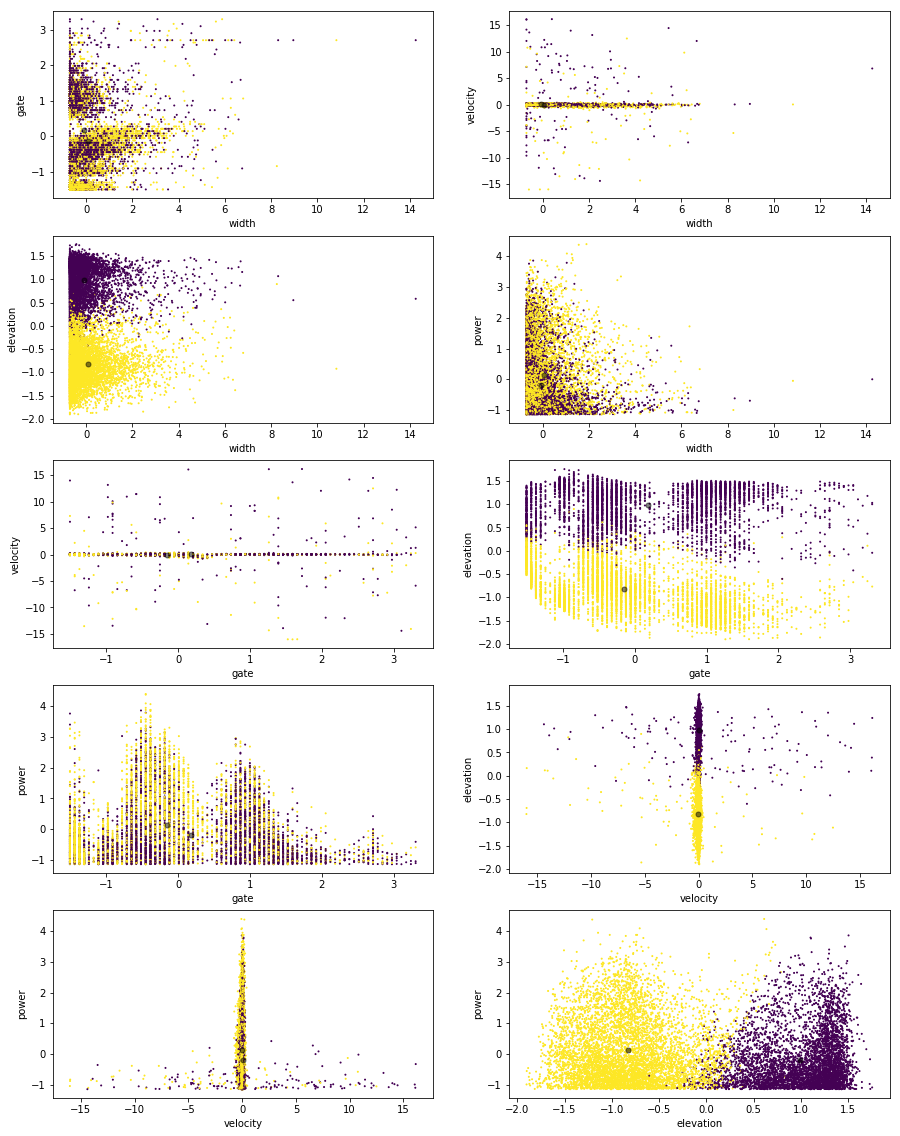

In [10]:
pylab.rcParams['figure.figsize'] = (15, 20)

#higher values of k (like 5 in the above elbow curve) are more optimal but we will use k=2 as a simple case for now since
#we have two classes: ionosphere backscatter and ground backscatter
#choosing the k-means model with k=2
k_means_optimal = kmeans_model[1]

#this code will subplot all possible valid combinations of the attributes
fig = plt.figure()
index = 1
for pair in itertools.combinations(attributes, 2):
    plt.subplot(5, 2, index)
    x_label = pair[0]
    y_label = pair[1]
    plt.scatter(X[:, attributes.index(x_label)], X[:, attributes.index(y_label)], c=k_means_optimal.predict(X), s=1, cmap='viridis')
    centers = k_means_optimal.cluster_centers_
    plt.scatter(centers[:, attributes.index(x_label)], centers[:, attributes.index(y_label)], c='black', s=25, alpha=0.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    index += 1
plt.show()

Since ground backscatter is characterised by low Doppler velocity (<~50 m/s) and low Doppler spectral width (<~50 m/s), we can further identify the cluster with comparatively lower velocity and width as ground scatter.

## Agglomerative Clustering

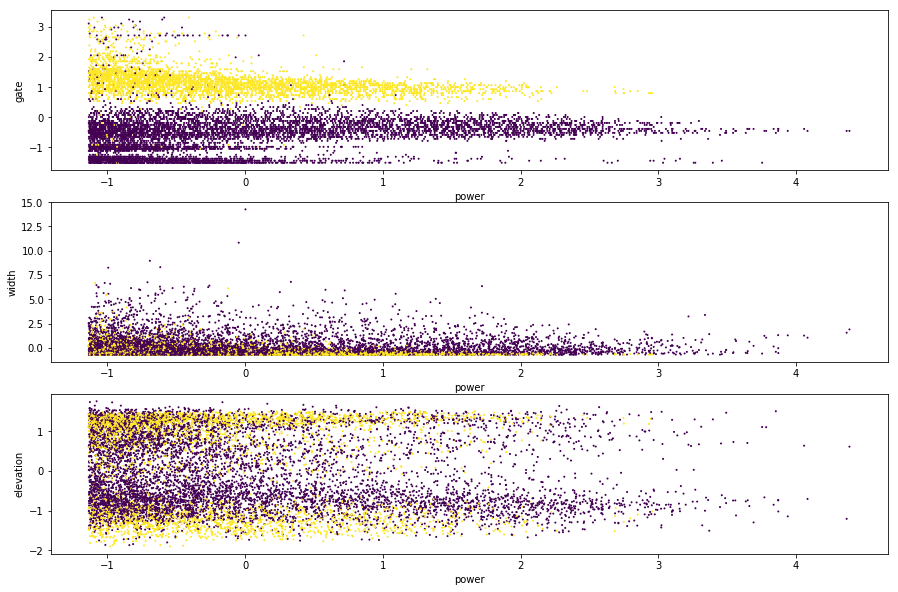

In [11]:
pylab.rcParams['figure.figsize'] = (15, 10)

#Agglomerative Clustering with ward as the linkage
#ward minimizes the variance of the clusters being merged
ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward')

ward.fit(X)
y_pred = ward.labels_.astype(np.int)
fig = plt.figure()
index = 1        
for pair in [("gate", "power"),("width", "power"),("elevation", "power")]  :
    plt.subplot(3, 1, index)
    x_label = pair[1]
    y_label = pair[0]
    plt.scatter(X[:, attributes.index(x_label)], X[:, attributes.index(y_label)], c=y_pred, s=1, cmap='viridis')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    index += 1
plt.show() 

## Clustering through Gaussian Mixture Models

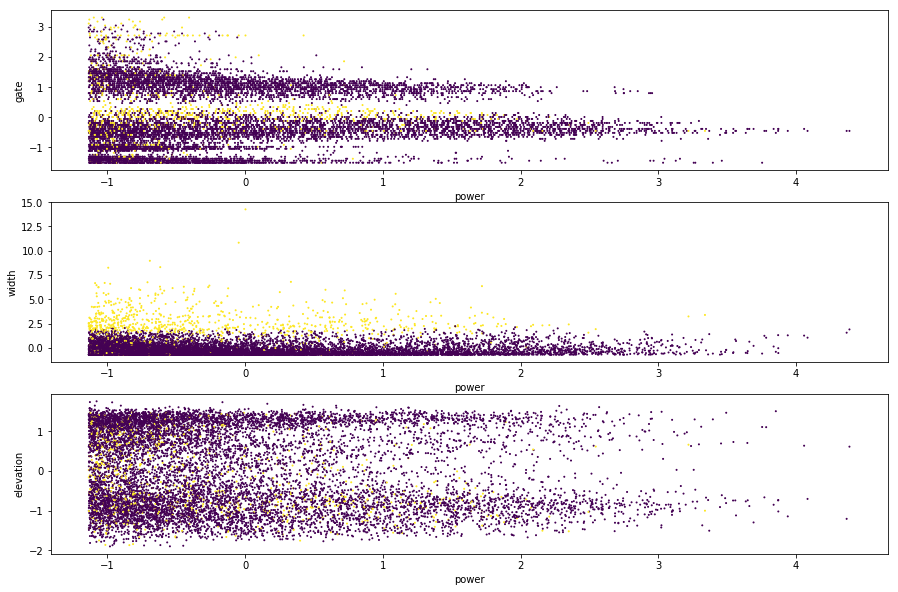

In [12]:
#creating a gaussian mixture models clustering object
gmm = GaussianMixture(n_components=2, covariance_type='full')    

gmm.fit(X)
y_pred = gmm.predict(X)    
fig = plt.figure()
index = 1        
for pair in [("gate", "power"),("width", "power"),("elevation", "power")]  :
    plt.subplot(3, 1, index)
    x_label = pair[1]
    y_label = pair[0]
    plt.scatter(X[:, attributes.index(x_label)], X[:, attributes.index(y_label)], c=y_pred, s=1, cmap='viridis')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    index += 1
plt.show()

In this quick start we have downloaded backscatter data from SuperDARN and clustered it into ground and ionospheric backscatter. Interesting future steps:
1. Experiment with different combinations of attributes
2. Use a dataset over a larger time period
3. Identify the ground backscatter cluster using the property of lower doppler velocity and width
4. Calculate the accuracy of your clustering labels against the SuperDARN's scatter type labels (hint: use the gflg values in your beam data)

Have fun!